# Assignment 1 - Luise Kutzner, Lara Ruschmeyer, Eva Franck

In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.utils import indexable
from sklearn.utils import resample
from sklearn.utils.validation import _num_samples
from sklearn.model_selection import ShuffleSplit, StratifiedShuffleSplit
from itertools import chain
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV, MultiTaskLassoCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from math import ceil, floor

from sklearn.utils import (
    _safe_indexing,
    check_random_state,
    indexable,
    metadata_routing,
)


# Task 1: Setting the Baseline

In [3]:
# function to transform the dataset into a DataFrame where each sample is labeled with 
# a 'trajectory_id' indicating which 258-sample trajectory it belongs to

def transform_to_trajectories_dataframe(X_data, idx):
    
    transformed_data = []
    
    # iterate through the indices list to slice the dataframe into stacks
    for i in range(len(idx) - 1):
        # each stack corresponds to samples from idx[i] to idx[i + 1]
        start_idx = idx[i]
        end_idx = idx[i + 1]
        
        trajectory = X_data.iloc[start_idx:end_idx].copy()
        
        trajectory['trajectory_id'] = i
        
        transformed_data.append(trajectory)
    
    result_df = pd.concat(transformed_data, ignore_index=True)
    
    return result_df


In [4]:
# removes trajectories from the dataset that have duplicated initial positions 

def remove_duplicated_trajectories(X_data, trajectory_col='trajectory_id'):
    
    first_samples = X_data.groupby(trajectory_col).first().reset_index()
    
    duplicated_first_samples = first_samples.duplicated(subset=X_data.columns.difference([trajectory_col]), keep='first')

    true_count = duplicated_first_samples.sum()
    index = duplicated_first_samples[duplicated_first_samples].index
    print(f"Found {true_count} duplicated first samples with indices {index}.")
    
    unique_trajectories = first_samples.loc[~duplicated_first_samples, trajectory_col]
    
    cleaned_data = X_data[X_data[trajectory_col].isin(unique_trajectories)]

    return cleaned_data


In [5]:
 # validation helper to check if the test/test sizes are meaningful with regard to 
 # the size of the data (used in test split function from sklearn)
    
def _validate_shuffle_split(n_samples, test_size, train_size, default_test_size=None):
   
    if test_size is None and train_size is None:
        test_size = default_test_size

    test_size_type = np.asarray(test_size).dtype.kind
    train_size_type = np.asarray(train_size).dtype.kind

    if (
        test_size_type == "i"
        and (test_size >= n_samples or test_size <= 0)
        or test_size_type == "f"
        and (test_size <= 0 or test_size >= 1)
    ):
        raise ValueError(
            "test_size={0} should be either positive and smaller"
            " than the number of samples {1} or a float in the "
            "(0, 1) range".format(test_size, n_samples)
        )

    if (
        train_size_type == "i"
        and (train_size >= n_samples or train_size <= 0)
        or train_size_type == "f"
        and (train_size <= 0 or train_size >= 1)
    ):
        raise ValueError(
            "train_size={0} should be either positive and smaller"
            " than the number of samples {1} or a float in the "
            "(0, 1) range".format(train_size, n_samples)
        )

    if train_size is not None and train_size_type not in ("i", "f"):
        raise ValueError("Invalid value for train_size: {}".format(train_size))
    if test_size is not None and test_size_type not in ("i", "f"):
        raise ValueError("Invalid value for test_size: {}".format(test_size))

    if train_size_type == "f" and test_size_type == "f" and train_size + test_size > 1:
        raise ValueError(
            "The sum of test_size and train_size = {}, should be in the (0, 1)"
            " range. Reduce test_size and/or train_size.".format(train_size + test_size)
        )

    if test_size_type == "f":
        n_test = ceil(test_size * n_samples)
    elif test_size_type == "i":
        n_test = float(test_size)

    if train_size_type == "f":
        n_train = floor(train_size * n_samples)
    elif train_size_type == "i":
        n_train = float(train_size)

    if train_size is None:
        n_train = n_samples - n_test
    elif test_size is None:
        n_test = n_samples - n_train

    if n_train + n_test > n_samples:
        raise ValueError(
            "The sum of train_size and test_size = %d, "
            "should be smaller than the number of "
            "samples %d. Reduce test_size and/or "
            "train_size." % (n_train + n_test, n_samples)
        )

    n_train, n_test = int(n_train), int(n_test)

    if n_train == 0:
        raise ValueError(
            "With n_samples={}, test_size={} and train_size={}, the "
            "resulting train set will be empty. Adjust any of the "
            "aforementioned parameters.".format(n_samples, test_size, train_size)
        )

    return n_train, n_test

In [6]:
# Redefine split function from sklearn for training and test set based on trajectories

def train_test_split_traj(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None, trajectory_col='trajectory_id'):

    n_arrays = len(arrays)
    if n_arrays == 0:
        raise ValueError("At least one array required as input")

    arrays = indexable(*arrays)

    # the first array should be the dataframe with trajectory column, otherwise raise error
    if isinstance(arrays[0], pd.DataFrame) and trajectory_col in arrays[0].columns:
        X_data = arrays[0]
        unique_trajectories = X_data[trajectory_col].unique()
    else:
        raise ValueError(f"The first array must be a DataFrame containing the column '{trajectory_col}'.")

    n_trajectories = len(unique_trajectories)
    
    # determine number of trajectories for training and testing
    n_train, n_test = _validate_shuffle_split(
        n_trajectories, test_size, train_size, default_test_size=0.25
    )

    # shuffle trajectories if needed
    if shuffle:
        np.random.seed(random_state)
        np.random.shuffle(unique_trajectories)

    if stratify is not None:
        raise ValueError("Stratified train/test split is not implemented for trajectories")

    # Split trajectories into training and test sets
    train_trajectories = unique_trajectories[:n_train]
    test_trajectories = unique_trajectories[n_train:n_train + n_test]

    # Create masks for train and test trajectories
    train_mask = X_data[trajectory_col].isin(train_trajectories)
    test_mask = X_data[trajectory_col].isin(test_trajectories)

    split_arrays = []
    for array in arrays:
        if isinstance(array, pd.DataFrame):
            train_array = array[train_mask]
            test_array = array[test_mask]
        else:
            train_array = array[train_mask.to_numpy()]
            test_array = array[test_mask.to_numpy()]

        split_arrays.extend([train_array, test_array])

    return split_arrays


In [7]:
# splits the dataset based on trajectories identified by the trajectory_id column into training, validation and test sets
# this or the function before
def train_validate_test_split(*arrays, test_size=None, validate_size=None, train_size=None, random_state=None, shuffle=True, trajectory_col='trajectory_id'):
    n_arrays = len(arrays)
    if n_arrays == 0:
        raise ValueError("At least one array required as input")

    arrays = indexable(*arrays)

    if isinstance(arrays[0], pd.DataFrame) and trajectory_col in arrays[0].columns:
        X_data = arrays[0]
        unique_trajectories = X_data[trajectory_col].unique()
    else:
        raise ValueError(f"The first array must be a DataFrame containing the column '{trajectory_col}'.")

    n_trajectories = len(unique_trajectories)

    # split the data into training and (validation + test)
    n_train, n_temp = _validate_shuffle_split(
        n_trajectories, test_size + validate_size, train_size, default_test_size=0.25
    )

    # shuffle trajectories if needed
    if shuffle:
        np.random.seed(random_state)
        np.random.shuffle(unique_trajectories)

    # split into train and temporary sets
    train_trajectories = unique_trajectories[:n_train]
    temp_trajectories = unique_trajectories[n_train:n_train + n_temp]

    # further split temporary set into validation and test sets
    n_validate = int(validate_size * n_trajectories)
    validate_trajectories = temp_trajectories[:n_validate]
    test_trajectories = temp_trajectories[n_validate:]

    # create masks for train, validation and test trajectories
    train_mask = X_data[trajectory_col].isin(train_trajectories)
    validate_mask = X_data[trajectory_col].isin(validate_trajectories)
    test_mask = X_data[trajectory_col].isin(test_trajectories)

    split_arrays = []
    for array in arrays:
        if isinstance(array, pd.DataFrame):
            train_array = array[train_mask]
            validate_array = array[validate_mask]
            test_array = array[test_mask]
        else:
            train_array = array[train_mask.to_numpy()]
            validate_array = array[validate_mask.to_numpy()]
            test_array = array[test_mask.to_numpy()]

        split_arrays.extend([train_array, validate_array, test_array])

    return split_arrays


## Task 1.1 Data Preparation and Validation Pipeline

In [9]:
data = pd.read_csv('../../mlNOVA/X_train.csv')
#data = pd.read_csv('X_train.csv')

In [10]:
data.head()


,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
0,0.000000,1.000000,0.000000,0.000000,0.000000,-0.266467,0.859196,0.000000,0.000000,-0.733533,-0.859196,0.000000,0.000000,0
1,0.039062,0.999548,0.000092,-0.023159,0.004731,-0.266261,0.858781,0.010574,-0.021257,-0.733287,-0.858874,0.012584,0.016526,1
2,0.078125,0.998190,0.000370,-0.046362,0.009474,-0.265641,0.857535,0.021172,-0.042552,-0.732549,-0.857905,0.025189,0.033078,2
3,0.117188,0.995925,0.000833,-0.069654,0.014239,-0.264606,0.855456,0.031817,-0.063924,-0.731318,-0.856289,0.037837,0.049685,3
4,0.156250,0.992747,0.001483,-0.093080,0.019040,-0.263154,0.852540,0.042533,-0.085412,-0.729592,-0.854022,0.050548,0.066372,4


In [12]:
data.loc[255:260]

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,Id
255,9.960940,1.491492,1.199018,-0.063145,0.595242,1.018416,1.248499,0.674080,-0.034194,-2.509908,-2.447517,-0.610936,-0.561048,255
256,10.000000,1.485476,1.222565,-0.250131,0.609230,1.048258,1.246830,0.859066,-0.050144,-2.533734,-2.469395,-0.608935,-0.559086,256
257,0.000000,1.000000,0.000000,0.000000,0.000000,-0.176502,0.555739,0.000000,0.000000,-0.823498,-0.555739,0.000000,0.000000,257
258,0.039062,0.999392,0.000131,-0.031160,0.006723,-0.176326,0.555148,0.008985,-0.030279,-0.823065,-0.555279,0.022176,0.023556,258
259,0.078125,0.997564,0.000525,-0.062415,0.013460,-0.175799,0.553372,0.017992,-0.060639,-0.821765,-0.553898,0.044423,0.047179,259
260,0.117188,0.994513,0.001183,-0.093859,0.020224,-0.174920,0.550408,0.027043,-0.091163,-0.819593,-0.551591,0.066816,0.070939,260


In [13]:
# find the indices where a new trajectory starts
idx = np.hstack((0, data[data.t == 10].index.values + 1))[:-1]

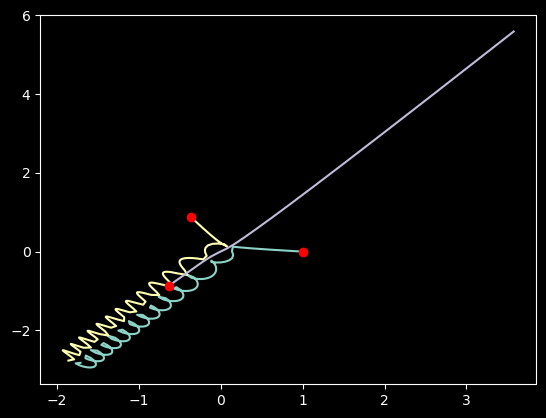

In [14]:
# plot a random trajectory 

k = np.random.randint(idx.shape[0])
pltidx = range(idx[k], 257 + idx[k])
pltsquare = idx[k]

plt.plot(data.x_1[pltidx], data.y_1[pltidx])
plt.plot(data.x_2[pltidx], data.y_2[pltidx])
plt.plot(data.x_3[pltidx], data.y_3[pltidx])

plt.plot(data.x_1[pltsquare], data.y_1[pltsquare], 'ro')
plt.plot(data.x_2[pltsquare], data.y_2[pltsquare], 'ro')
plt.plot(data.x_3[pltsquare], data.y_3[pltsquare], 'ro')

In [15]:
# drop Id column as it is unnecessary for the model
data_cleaned = data.drop(columns=['Id'])
#'v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3', 

In [16]:
# Extract the X data and bring it into a form such that you have the initial conditions 
# along with the time t at which y describes the current x and y positions

X_data = data_cleaned.copy()
for i in idx:
    # select the first sample's column values in the current trajectory
    x_1_value = data_cleaned.loc[i, 'x_1']
    y_1_value = data_cleaned.loc[i, 'y_1']
    x_2_value = data_cleaned.loc[i, 'x_2']
    y_2_value = data_cleaned.loc[i, 'y_2']
    x_3_value = data_cleaned.loc[i, 'x_3']
    y_3_value = data_cleaned.loc[i, 'y_3']
    
    # update the column values for all 258 samples in this trajectory
    X_data.loc[i:i+257, 'x_1'] = x_1_value
    X_data.loc[i:i+257, 'y_1'] = y_1_value
    X_data.loc[i:i+257, 'x_2'] = x_2_value
    X_data.loc[i:i+257, 'y_2'] = y_2_value
    X_data.loc[i:i+257, 'x_3'] = x_3_value
    X_data.loc[i:i+257, 'y_3'] = y_3_value
    X_data.loc[i:i+257, 'v_x_1'] = 0
    X_data.loc[i:i+257, 'v_y_1'] = 0
    X_data.loc[i:i+257, 'v_x_2'] = 0
    X_data.loc[i:i+257, 'v_y_2'] = 0
    X_data.loc[i:i+257, 'v_x_3'] = 0
    X_data.loc[i:i+257, 'v_y_3'] = 0


In [18]:
X_data.head()

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3
0,0.000000,1.0,0.0,0.0,0.0,-0.266467,0.859196,0.0,0.0,-0.733533,-0.859196,0.0,0.0
1,0.039062,1.0,0.0,0.0,0.0,-0.266467,0.859196,0.0,0.0,-0.733533,-0.859196,0.0,0.0
2,0.078125,1.0,0.0,0.0,0.0,-0.266467,0.859196,0.0,0.0,-0.733533,-0.859196,0.0,0.0
3,0.117188,1.0,0.0,0.0,0.0,-0.266467,0.859196,0.0,0.0,-0.733533,-0.859196,0.0,0.0
4,0.156250,1.0,0.0,0.0,0.0,-0.266467,0.859196,0.0,0.0,-0.733533,-0.859196,0.0,0.0


In [19]:
# copy the X_train data to obtain y_data dataframe which are the positions 
# and velocities of all three objects at a certain time t
y_data = data_cleaned.copy()

In [20]:
# add a trajectory_id flag such that the data can be split into trajectories (function is defined above)
X_data_traj = transform_to_trajectories_dataframe(X_data, idx)
y_data_traj = transform_to_trajectories_dataframe(y_data, idx)


In [21]:
# remove trajectories with duplicated initial positions (function is defined above)
cleaned_X_data = remove_duplicated_trajectories(X_data_traj, trajectory_col='trajectory_id')
cleaned_y_data = remove_duplicated_trajectories(y_data_traj, trajectory_col='trajectory_id')

Found 1 duplicated first samples with indices Index([3297], dtype='int64').
Found 1 duplicated first samples with indices Index([3297], dtype='int64').


In [22]:
# split data into training, validation and test sets with the training size of 80%, validation size of 10% and test size of 10% (function is defined above)
X_train, X_val, X_test, y_train, y_val, y_test = train_validate_test_split(cleaned_X_data, cleaned_y_data, validate_size= 0.1, test_size=0.1)

Remove the trajectory_id column as it was only necessary for the splitting once with t in training and validation data, once without and once only in training data

In [23]:
# # Remove the trajectory_id column as it was only necessary for the splitting

# X_train = X_train.drop(columns=['trajectory_id'])
# X_val = X_val.drop(columns=['trajectory_id'])
# X_test = X_test.drop(columns=['trajectory_id'])
# y_train = y_train.drop(columns=['trajectory_id'])
# y_val = y_val.drop(columns=['trajectory_id'])
# y_test = y_test.drop(columns=['trajectory_id'])

In [58]:
# Remove the trajectory_id column for all sets and t for the y_datasets
# otherwise (the prediction will overfit) the RSME will be much different from kaggle

X_train = X_train.drop(columns=['trajectory_id'])
X_val = X_val.drop(columns=['trajectory_id'])
X_test = X_test.drop(columns=['trajectory_id'])
y_train = y_train.drop(columns=['trajectory_id', 't'])
y_val = y_val.drop(columns=['trajectory_id', 't'])
y_test = y_test.drop(columns=['trajectory_id', 't'])

In [59]:
# X_train = X_train.drop(columns=['trajectory_id', 't'])
# X_val = X_val.drop(columns=['trajectory_id', 't'])
# X_test = X_test.drop(columns=['trajectory_id', 't'])
# y_train = y_train.drop(columns=['trajectory_id', 't'])
# y_val = y_val.drop(columns=['trajectory_id', 't'])
# y_test = y_test.drop(columns=['trajectory_id', 't'])

## 1.2 Learn the baseline model

In [60]:
# create pipeline with a standard scaler and a linear regression model
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()), 
    ('regressor', LinearRegression())  
])


pipeline.fit(X_train, y_train)
pipeline['regressor'].score(X_train, y_train)
#pipeline['regressor'].coef_
#pipeline['regressor'].intercept_

/Users/lari/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


-1016609224605374.9

In [61]:
# predict y values for the validation set
y_val_pred = pipeline.predict(X_val)

In [62]:
# # make a dataframe out of the true and predicted y values for the validation set to compare them
# # and calculate the root mean squared error for the predicted values of the validation set 
# # in comparison to the true values and for that drop the velocities from the dataframe
# y_val_pred_df = pd.DataFrame(y_val_pred, columns=X_val.columns)
# y_val_pred_df.drop(columns=['t', 'v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3'], inplace=True)
# y_val.drop(columns=['t', 'v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3'], inplace=True)
# rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_df))
# print(f'Root Mean Squared Error: {rmse}')

In [63]:
# make a dataframe out of the true and predicted y values for the validation set to compare them
# and calculate the root mean squared error for the predicted values of the validation set 
# in comparison to the true values and for that drop the velocities from the dataframe
X_val_without_t = X_val.drop(columns=['t'])
y_val_pred_df = pd.DataFrame(y_val_pred, columns=X_val_without_t.columns)
y_val_pred_df.drop(columns=['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3'], inplace=True)
y_val.drop(columns=['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3'], inplace=True)
rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_df))
print(f'Root Mean Squared Error: {rmse}')

Root Mean Squared Error: 1.2171185307162902


In [64]:
# # make a dataframe out of the true and predicted y values for the validation set to compare them
# # and calculate the root mean squared error for the predicted values of the validation set 
# # in comparison to the true values and for that drop the velocities from the dataframe
# y_val_pred_df = pd.DataFrame(y_val_pred, columns=X_val.columns)
# y_val_pred_df.drop(columns=['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3'], inplace=True)
# y_val.drop(columns=['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3'], inplace=True)
# rmse = np.sqrt(mean_squared_error(y_val, y_val_pred_df))
# print(f'Root Mean Squared Error: {rmse}')

In [65]:
# function to plot the true values against the predicted values for the validation set

def plot_y_yhat(y_val,y_pred, plot_title = "plot"):
    labels = ['x_1','y_1','x_2','y_2','x_3','y_3']
    MAX = 500
    if len(y_val) > MAX:
        idx = np.random.choice(len(y_val),MAX, replace=False)
    else:
        idx = np.arange(len(y_val))
    
    plt.figure(figsize=(10,10))
    for i in range(6):
        x0 = np.min(y_val[idx,i])
        x1 = np.max(y_val[idx,i])
        plt.subplot(3, 2, i+1)
        plt.scatter(y_val[idx,i],y_pred[idx,i])
        plt.xlabel('True '+labels[i])
        plt.ylabel('Predicted '+labels[i])
        plt.plot([x0,x1],[x0,x1],color='red')
        plt.axis('square')
    #plt.savefig(plot_title+'.pdf')
    plt.show()

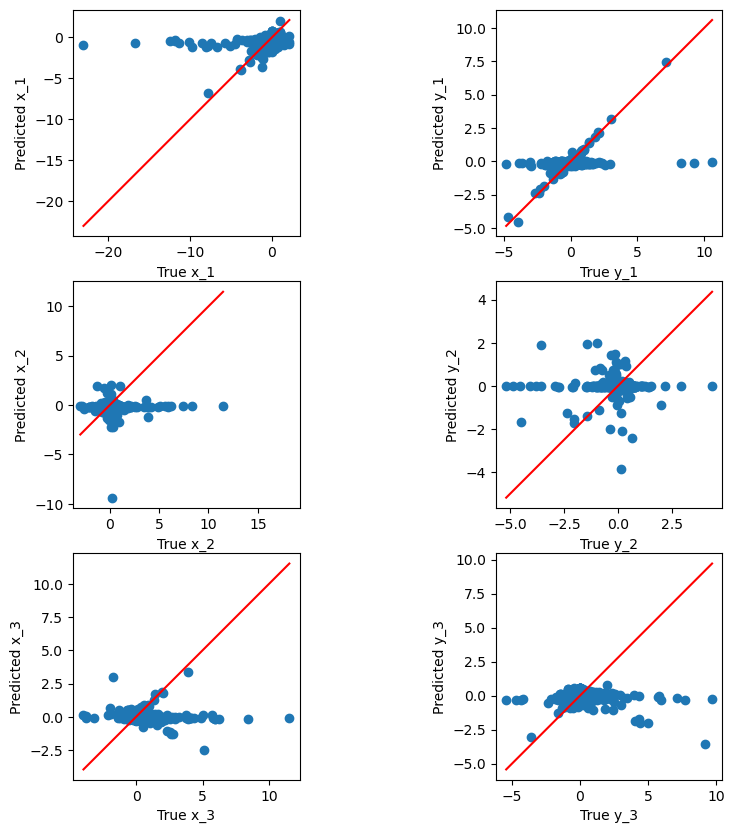

In [66]:
# make a numpy array out of y_val and plot it against the predicted values with the function above
y_val_np = y_val.to_numpy()
y_pred_np = y_val_pred_df.to_numpy()
plot_y_yhat(y_val_np,y_val_pred)

In [67]:
# bring the data that we should apply the model on in the right format
# and predict the y values with our model
data2 = pd.read_csv('../mlNOVA/X_test.csv')

data2['x_1'] = data2['x0_1']
data2['y_1'] = data2['y0_1']
data2['v_x_1'] = 0
data2['v_y_1'] = 0
data2['x_2'] = data2['x0_2']
data2['y_2'] = data2['y0_2']
data2['v_x_2'] = 0
data2['v_y_2'] = 0
data2['x_3'] = data2['x0_3']
data2['y_3'] = data2['y0_3']
data2['v_x_3'] = 0
data2['v_y_3'] = 0

data2 = data2.drop(columns=['Id', 'x0_1', 'y0_1', 'x0_2', 'y0_2', 'x0_3', 'y0_3'])


y_data2 = pipeline.predict(data2)

# save y values for the data we should test the model on in the right format for kaggle
y_data2 = pd.DataFrame(y_data2, columns=X_val_without_t.columns)
y_data2['id'] = y_data2.index

columns_titles = ['id', 't', 'x_1', 'y_1', 'v_x_1', 'v_y_1', 'x_2', 'y_2', 'v_x_2', 'v_y_2',
       'x_3', 'y_3', 'v_x_3', 'v_y_3'] 
y_data2=y_data2.reindex(columns=columns_titles)
y_data2.drop(columns=['t', 'v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3'], inplace=True)
y_data2.to_csv('sample_submission.csv',index=False)

In [68]:
# # bring the data that we should apply the model on in the right format
# # and predict the y values with our model
# data2 = pd.read_csv('../mlNOVA/X_test.csv')

# data2['x_1'] = data2['x0_1']
# data2['y_1'] = data2['y0_1']
# data2['v_x_1'] = 0
# data2['v_y_1'] = 0
# data2['x_2'] = data2['x0_2']
# data2['y_2'] = data2['y0_2']
# data2['v_x_2'] = 0
# data2['v_y_2'] = 0
# data2['x_3'] = data2['x0_3']
# data2['y_3'] = data2['y0_3']
# data2['v_x_3'] = 0
# data2['v_y_3'] = 0

# data2 = data2.drop(columns=['Id', 't', 'x0_1', 'y0_1', 'x0_2', 'y0_2', 'x0_3', 'y0_3'])


# y_data2 = pipeline.predict(data2)

# # save y values for the data we should test the model on in the right format for kaggle
# y_data2 = pd.DataFrame(y_data2, columns=X_val.columns)
# y_data2['id'] = y_data2.index

# columns_titles = ['id', 'x_1', 'y_1', 'v_x_1', 'v_y_1', 'x_2', 'y_2', 'v_x_2', 'v_y_2',
#        'x_3', 'y_3', 'v_x_3', 'v_y_3'] 
# y_data2=y_data2.reindex(columns=columns_titles)
# y_data2.drop(columns=['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3'], inplace=True)
# y_data2.to_csv('sample_submission.csv',index=False)

# Task 2: Nonlinear models on the data - the Polynomial Regression Model

## Task 2.1 Development

In [69]:
# split the data again into training, validation and test sets with the training size of 80%, validation size of 10% and test size of 10%
X_train, X_val, X_test, y_train, y_val, y_test = train_validate_test_split(cleaned_X_data, cleaned_y_data, validate_size= 0.1, test_size=0.1)

In [70]:
y_val

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,trajectory_id
2570,0.000000,1.000000,0.000000,0.000000,0.000000,-0.278797,0.495081,0.000000,0.000000,-0.721203,-0.495081,0.000000,0.000000,8
2571,0.039062,0.999393,0.000081,-0.031091,0.004134,-0.278683,0.494342,0.005820,-0.037850,-0.720710,-0.494423,0.025271,0.033716,8
2572,0.078125,0.997570,0.000323,-0.062275,0.008268,-0.278342,0.492122,0.011615,-0.075862,-0.719228,-0.492445,0.050660,0.067594,8
2573,0.117188,0.994525,0.000727,-0.093648,0.012405,-0.277776,0.488411,0.017361,-0.114203,-0.716749,-0.489138,0.076287,0.101798,8
2574,0.156250,0.990250,0.001292,-0.125306,0.016544,-0.276987,0.483193,0.023026,-0.153048,-0.713263,-0.484485,0.102280,0.136505,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1284738,9.843750,-0.408051,-0.012284,1.189426,-0.815697,-0.424418,-0.404970,-0.307460,1.010425,0.832469,0.417254,-0.881966,-0.194728,4051
1284739,9.882810,-0.361738,-0.049591,1.169348,-1.114156,-0.435557,-0.359714,-0.249920,1.326808,0.797296,0.409304,-0.919429,-0.212652,4051
1284740,9.921880,-0.318596,-0.101519,0.993035,-1.583569,-0.441999,-0.299089,-0.032856,1.816586,0.760596,0.400609,-0.960179,-0.233017,4051
1284741,9.960940,-0.292853,-0.176693,0.083473,-2.268009,-0.429385,-0.214368,0.920770,2.524340,0.722238,0.391061,-1.004243,-0.256331,4051


In [71]:
# sample 1% of the sets

def sample_trajectories(X, y, trajectory_col='trajectory_id', sample_fraction=0.01, random_state=42):

    unique_trajectories = X[trajectory_col].unique()
  
    sampled_trajectories = resample(unique_trajectories, n_samples=int(sample_fraction * len(unique_trajectories)), random_state=random_state)
    
    X_sampled = X[X[trajectory_col].isin(sampled_trajectories)]
    y_sampled = y[X[trajectory_col].isin(sampled_trajectories)]
    
    return X_sampled, y_sampled

X_train_sampled, y_train_sampled = sample_trajectories(X_train, y_train, sample_fraction=0.01)
X_val_sampled, y_val_sampled = sample_trajectories(X_val, y_val, sample_fraction=0.01)
X_test_sampled, y_test_sampled = sample_trajectories(X_test, y_test, sample_fraction=0.01)

In [72]:
y_val_sampled.head()

,t,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3,trajectory_id
303774,0.000000,1.000000,0.000000,0.000000,0.000000,-0.431960,0.033431,0.00000,0.000000,-0.568040,-0.033431,0.000000,0.000000,962
303775,0.039062,0.999319,0.000002,-0.034875,0.000077,-0.468287,0.015396,-2.47452,-1.224854,-0.531032,-0.015398,2.509394,1.224777,962
303776,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,962
303777,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,962
303778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,962


In [73]:
# # Remove the trajectory_id column for all sets and t for the y_datasets
# otherwise (the prediction will overfit) the RSME will be much different from kaggle
X_train_sampled = X_train_sampled.drop(columns=['trajectory_id'])
X_val_sampled = X_val_sampled.drop(columns=['trajectory_id'])
X_test_sampled = X_test_sampled.drop(columns=['trajectory_id'])
y_train_sampled = y_train_sampled.drop(columns=['trajectory_id', 't'])
y_val_sampled = y_val_sampled.drop(columns=['trajectory_id', 't'])
y_test_sampled = y_test_sampled.drop(columns=['trajectory_id', 't'])

In [74]:
y_val_sampled

,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3
303774,1.000000,0.000000,0.000000,0.000000,-0.431960,0.033431,0.000000,0.000000,-0.568040,-0.033431,0.000000,0.000000
303775,0.999319,0.000002,-0.034875,0.000077,-0.468287,0.015396,-2.474520,-1.224854,-0.531032,-0.015398,2.509394,1.224777
303776,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
303777,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
303778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
1142103,-1.423530,1.301105,0.127118,0.078017,0.680313,-0.935695,0.678598,0.097079,0.743217,-0.365410,-0.805717,-0.175096
1142104,-1.418428,1.304031,0.134112,0.071783,0.706946,-0.929484,0.682989,0.222357,0.711482,-0.374546,-0.817101,-0.294140
1142105,-1.413052,1.306712,0.141126,0.065485,0.733498,-0.918199,0.674000,0.357157,0.679554,-0.388513,-0.815126,-0.422642
1142106,-1.407402,1.309146,0.148155,0.059118,0.759380,-0.901439,0.647867,0.502890,0.648023,-0.407707,-0.796022,-0.562008


In [75]:
# perform polynomial regression with different polynomial degrees and different regressors
def validate_poly_regression(X_train, y_train, X_val, y_val, regressor=None, degrees=range(1,15), max_features=None):
    
    if regressor is None:
        regressor = LinearRegression()
    elif regressor == 'MultiTaskLassoCV':
        regressor = MultiTaskLassoCV(alphas=np.logspace(-6, 6, 10), cv = 5)
    elif regressor == 'RidgeCV':
        regressor = RidgeCV(alphas=np.logspace(-6, 6, 10), store_cv_values=True)
    else:
        raise ValueError("Invalid regressor type.")
    
    best_rmse = float('inf')
    rmse_dict = {}
    best_pipeline = None

    
    # iterate through the polynomial degrees
    for degree in degrees:
        # pipeline for polynomial regression
        pipeline = Pipeline(steps=[
                ('poly', PolynomialFeatures(degree=degree)),
                ('scaler', StandardScaler()),
                ('regressor', regressor)
            ])
        
        pipeline.fit(X_train, y_train)
        
        # number of features for each degree
        poly_features = pipeline.named_steps['poly']
        print(f'Degree: {degree}, Number of Features: {poly_features.n_output_features_}')
        
        if max_features is not None and poly_features.n_output_features_ > max_features:
            print(f"Skipping degree {degree} as it exceeds max_features={max_features}.")
            continue
        
        y_val_pred = pipeline.predict(X_val)
        
        num_features = pipeline.named_steps['poly'].n_output_features_
        
        X_val_without_t = X_val.drop(columns=['t'])
        y_val_pred_df = pd.DataFrame(y_val_pred, columns=X_val_without_t.columns)
        y_val_pred_df.drop(columns=['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3'], inplace=True)
        y_val_eval = y_val.copy()
        y_val_eval.drop(columns=['v_x_1', 'v_y_1', 'v_x_2', 'v_y_2', 'v_x_3', 'v_y_3'], inplace=True)

        rmse = np.sqrt(mean_squared_error(y_val_eval, y_val_pred_df))
        print(f'Degree: {degree}, RMSE: {rmse}')
        
        rmse_dict[degree] = rmse
        
        # update the best degree if the current model is better
        if rmse < best_rmse:
            best_rmse = rmse
            best_pipeline = pipeline
        
        if max_features is not None and num_features > max_features:
            break
        
    return rmse_dict, best_rmse, best_pipeline
    
    

In [76]:
y_val_sampled

,x_1,y_1,v_x_1,v_y_1,x_2,y_2,v_x_2,v_y_2,x_3,y_3,v_x_3,v_y_3
303774,1.000000,0.000000,0.000000,0.000000,-0.431960,0.033431,0.000000,0.000000,-0.568040,-0.033431,0.000000,0.000000
303775,0.999319,0.000002,-0.034875,0.000077,-0.468287,0.015396,-2.474520,-1.224854,-0.531032,-0.015398,2.509394,1.224777
303776,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
303777,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
303778,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
1142103,-1.423530,1.301105,0.127118,0.078017,0.680313,-0.935695,0.678598,0.097079,0.743217,-0.365410,-0.805717,-0.175096
1142104,-1.418428,1.304031,0.134112,0.071783,0.706946,-0.929484,0.682989,0.222357,0.711482,-0.374546,-0.817101,-0.294140
1142105,-1.413052,1.306712,0.141126,0.065485,0.733498,-0.918199,0.674000,0.357157,0.679554,-0.388513,-0.815126,-0.422642
1142106,-1.407402,1.309146,0.148155,0.059118,0.759380,-0.901439,0.647867,0.502890,0.648023,-0.407707,-0.796022,-0.562008


In [77]:
# validate the polynomial regression with degrees from 1 to 7 and linear regressor
rmse_dict_linear, best_rmse_linear, best_pipeline_linear = validate_poly_regression(X_train_sampled, y_train_sampled, X_val_sampled, y_val_sampled, regressor=None, degrees=range(1,3), max_features=None)

Degree: 1, Number of Features: 14
Degree: 1, RMSE: 0.7863041487878727
Degree: 2, Number of Features: 105
Degree: 2, RMSE: 1.393909709317703


In [78]:
# validate the polynomial regression with degrees from 1 to 7 and Lasso regressor
rmse_dict_lasso, best_rmse_lasso, best_pipeline_lasso = validate_poly_regression(X_train_sampled, y_train_sampled, X_val_sampled, y_val_sampled, regressor='MultiTaskLassoCV', degrees=range(1,3), max_features=None)

/Users/lari/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:675: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2027.0962113896385, tolerance: 26.91444205740759
  model = cd_fast.enet_coordinate_descent_multi_task(
/Users/lari/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:675: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2439.6618074571306, tolerance: 26.91444205740759
  model = cd_fast.enet_coordinate_descent_multi_task(
/Users/lari/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:675: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2471.4539811330324, tolerance: 26.91444205740759
  model = cd_fast.enet_coordinate_descent_multi_task(
/Users/lari/o

Degree: 1, Number of Features: 14
Degree: 1, RMSE: 0.6319531080889604


/Users/lari/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:675: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 9730.447613533295, tolerance: 26.91444205740759
  model = cd_fast.enet_coordinate_descent_multi_task(
/Users/lari/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:675: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 85026.99818477998, tolerance: 26.91444205740759
  model = cd_fast.enet_coordinate_descent_multi_task(
/Users/lari/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:675: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 101536.03889806644, tolerance: 26.91444205740759
  model = cd_fast.enet_coordinate_descent_multi_task(
/Users/lari/opt

Degree: 2, Number of Features: 105
Degree: 2, RMSE: 0.6319531080889604


/Users/lari/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:675: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 44747.70619887872, tolerance: 13.402529056866154
  model = cd_fast.enet_coordinate_descent_multi_task(


In [79]:
# validate the polynomial regression with degrees from 1 to 7 and RidgeCV regressor
rmse_dict_ridge, best_rmse_ridge, best_pipeline_ridge = validate_poly_regression(X_train_sampled, y_train_sampled, X_val_sampled, y_val_sampled, regressor='RidgeCV', degrees=range(1,3), max_features=None)

/Users/lari/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


Degree: 1, Number of Features: 14
Degree: 1, RMSE: 0.7315480943451348
Degree: 2, Number of Features: 105
Degree: 2, RMSE: 0.9789970799690156


/Users/lari/opt/anaconda3/envs/ml/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:2341: FutureWarning: 'store_cv_values' is deprecated in version 1.5 and will be removed in 1.7. Use 'store_cv_results' instead.
  warnings.warn(


In [80]:
rmse_dict_linear

{1: 0.7863041487878727, 2: 1.393909709317703}

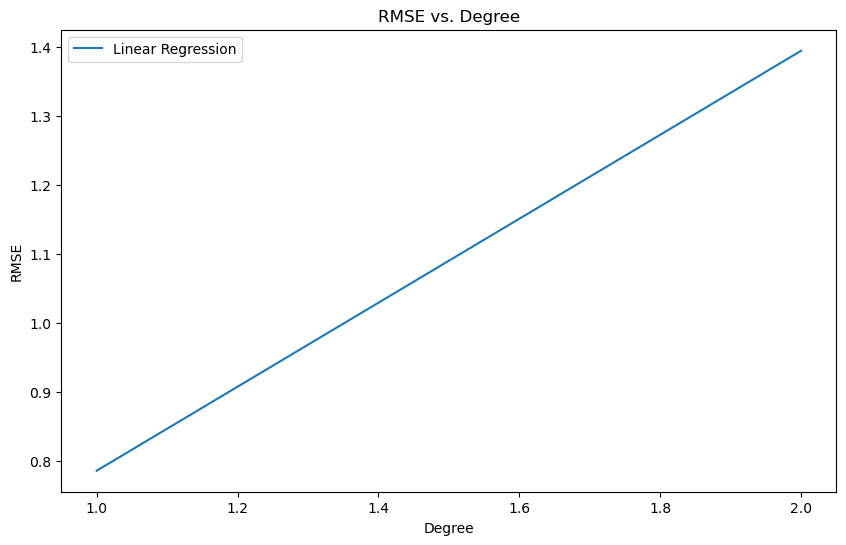

In [81]:
# make a plot of the distribution of the different polynomial degrees

plt.figure(figsize=(10,6))
plt.plot(*zip(*rmse_dict_linear.items()), label='Linear Regression')
#plt.plot(, values, label='Lasso Regression')
#plt.plot(*zip(*rmse_dict_ridge.items()), label='Ridge Regression')
plt.xlabel('Degree')
plt.ylabel('RMSE')
plt.title('RMSE vs. Degree')
plt.legend()
plt.show()

# Task 4: Nonparamentric Model — the k-Nearest Neighbors Regressor

## Task 4.1 Development

In [85]:
import time
from sklearn.neighbors import KNeighborsRegressor

In [86]:
def validate_knn_regression(X_train, y_train, X_val, y_val, k=range(1,15)):
    results = {
        'k': [],
        'train_time': [],
        'inference_time': [],
        'validation_error': []
    }
    
    for i in k:
        # Create the kNN model
        knn = KNeighborsRegressor(n_neighbors=i)
        
        # Measure training time
        start_train = time.time()
        knn.fit(X_train, y_train)
        end_train = time.time()
        train_time = end_train - start_train
        
        # Measure inference time
        start_inference = time.time()
        y_pred = knn.predict(X_val)
        end_inference = time.time()
        inference_time = end_inference - start_inference
        
        # Calculate the validation error
        error = mean_squared_error(y_val, y_pred)
        
        # Save results
        results['k'].append(i)
        results['train_time'].append(train_time)
        results['inference_time'].append(inference_time)
        results['validation_error'].append(error)
    
    # Convert the results to a DataFrame for easier analysis
    results_df = pd.DataFrame(results)
    return results_df

In [87]:
validate_knn_regression(X_train, y_train, X_val, y_val, k=range(1,15))

,k,train_time,inference_time,validation_error
0,1,2.554412,1.574513,2.167230
1,2,1.391850,1.522968,2.087229
2,3,1.341897,1.560511,2.053689
3,4,1.493847,1.601127,2.030414
4,5,1.592819,1.769062,2.013991
5,6,1.316650,1.743138,1.995605
6,7,1.358885,1.661973,1.983916
7,8,1.280445,1.699717,1.972138
8,9,1.334814,1.810347,1.965978
9,10,1.394548,1.905711,1.959383


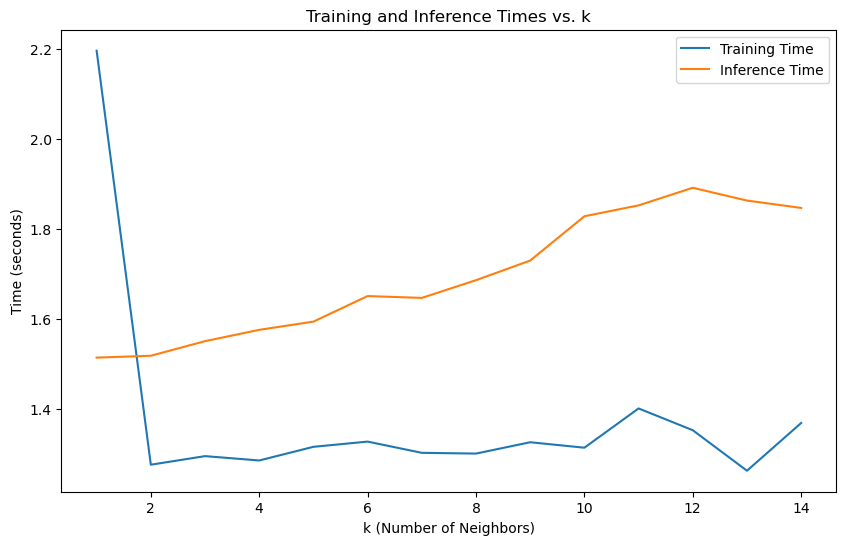

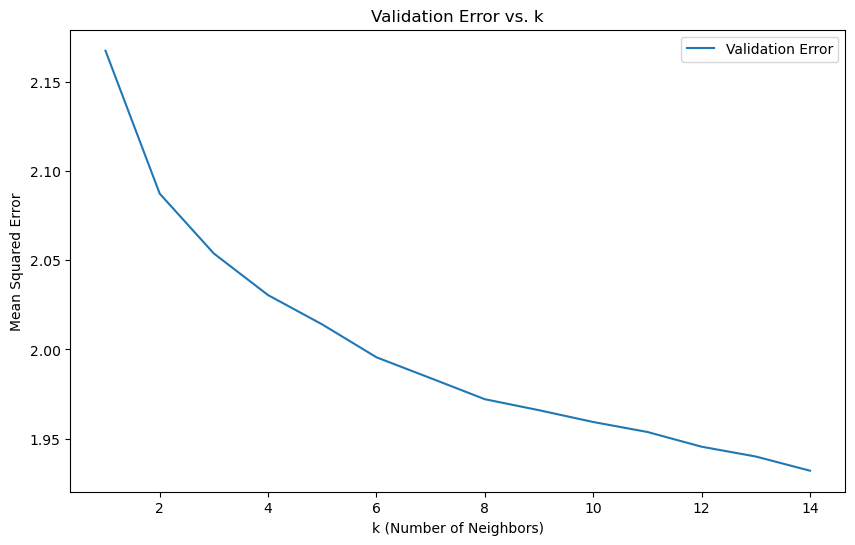

In [88]:
results_df = validate_knn_regression(X_train, y_train, X_val, y_val)

# Plot training time vs k
plt.figure(figsize=(10, 6))
plt.plot(results_df['k'], results_df['train_time'], label='Training Time')
plt.plot(results_df['k'], results_df['inference_time'], label='Inference Time')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Time (seconds)')
plt.title('Training and Inference Times vs. k')
plt.legend()
plt.show()

# Plot validation error vs k
plt.figure(figsize=(10, 6))
plt.plot(results_df['k'], results_df['validation_error'], label='Validation Error')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Mean Squared Error')
plt.title('Validation Error vs. k')
plt.legend()
plt.show()